## Tensorflow tutorial 1: Models and training

Don't panic, read the docs (https://www.tensorflow.org/beta)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm

### 1) Classifying hand-written digits / MNIST dataset
Contents:
- `tf.keras.models.Sequential`
- `tf.keras.layers.*`

- Obtain data
- Constructing a model
- Choose a loss function
- Training
- Validation

In [3]:
mnist = tf.keras.datasets.mnist

Load data

In [4]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

First dimension identifies sample

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

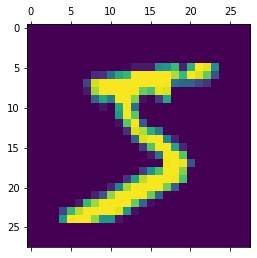

In [6]:
plt.matshow(x_train[0])

In [7]:
y_train[0]

5

Formulate a model $f_w(x)$ and attach loss function and observables

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Note that we use the __Sequential__ API here, i.e. we define the computation graph when `model` is constructed. Tensorflow (Keras) also supports a __functional__ API (https://www.tensorflow.org/beta/guide/keras/functional) in which you procedurally build the graph (potentially with branches), and then construct a model from this.

Model is randomly initialized, applying the forward pass to the image of the five will not yield a reliable prediction.

Text(0, 0.5, 'Assignment probability')

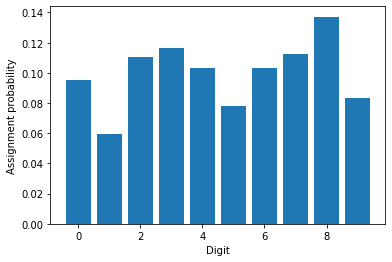

In [9]:
prediction = model.apply(x_train[0:1])
plt.bar(range(0,10), prediction[0])
plt.xlabel("Digit")
plt.ylabel("Assignment probability")

Train the model

In [10]:
model.fit(x_train, y_train, epochs=3)

W0821 10:52:32.813738 140109521061696 deprecation.py:323] From /home/ms/github/venv/bmsss/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 7s 118us/sample - loss: 0.2196 - accuracy: 0.9343
Epoch 2/3
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0958 - accuracy: 0.9706
Epoch 3/3
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0676 - accuracy: 0.9788


Apply model again to the image of the five

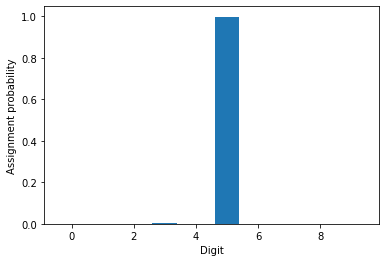

In [11]:
prediction = model.apply(x_train[0:1])
plt.bar(range(0,10), prediction[0])
plt.xlabel("Digit")
plt.ylabel("Assignment probability");

More interestingly we can evaluate the performance on unseen data

In [12]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 49us/sample - loss: 0.0758 - accuracy: 0.9769


[0.07582823429312557, 0.9769]

### 2) MNIST using convolutional layers
Contents:
- functional api to construct models, `tf.keras.Input`
- `tf.keras.layers.Conv2D`
- `tf.keras.optimizers`
- `tf.keras.losses`
- `tf.keras.metrics`
- `tf.data.Dataset`

- Constructing a model (convolutions better suited for images compared to dense)
- Validation

![](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)
image taken from wikipedia

We use a convolutional layer with 32 filters, each one with a size 3x3

In [13]:
inputs = tf.keras.Input(shape=(28, 28, 1))
inputs.shape

TensorShape([None, 28, 28, 1])

In [14]:
functional_api = True
if not functional_api:
    conv_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
else:
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    conv_model = tf.keras.Model(inputs=inputs, outputs=outputs)

conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [15]:
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


We now use the `tf.data.Dataset`, which generalizes data coming from different sources. Here we will simply consume our `np.ndarray` objects. The `Dataset` supports functions like [`apply`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#apply), [`batch`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#batch), [`shuffle`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#shuffle), [`map`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#map)

In [16]:
# Construct the dataset from numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Add channel dimension
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))
test_dataset= test_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y))

# which on direct numpy data would be
x_train2 = x_train[..., np.newaxis]
x_test2 = x_test[..., np.newaxis]

# Batch data
train_dataset = train_dataset.shuffle(len(x_train)).batch(64)
test_dataset= test_dataset.batch(64)

Label tf.Tensor([8], shape=(1,), dtype=uint8)


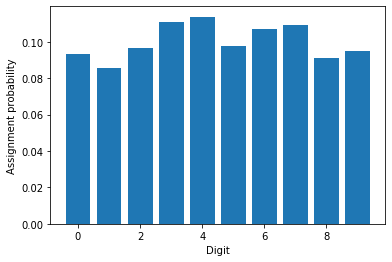

In [17]:
image, label = next(train_dataset.__iter__())
prediction = conv_model.apply(image[0:1])
plt.bar(range(0,10), prediction[0])
plt.xlabel("Digit")
plt.ylabel("Assignment probability")
print("Label", label[0:1])

In [18]:
conv_model.fit(train_dataset, epochs=2)

Epoch 1/2
938/938 [==============================] - 41s 44ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.9553
Epoch 2/2
938/938 [==============================] - 40s 42ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9862


In [19]:
conv_model.evaluate(test_dataset)

157/157 [==============================] - 3s 16ms/step - loss: 0.0750 - sparse_categorical_accuracy: 0.9737


[0.07503826021710648, 0.9737]

### 3) Linear regression, example Hooke's law of a two-dimensional oscillator
- subclass `tf.keras.Model`
- `tf.keras.Model.save_weights`
- `tf.keras.Model.load_weights`
- Constructing a (linear) model

Given a point mass is attached to two springs such that it can oscillate in two orthogonal directions  independently. Given measurements of the force on the point mass at given excitations $x$, we want to find a model that predicts the force from $x$. Our model for the resetting force $F\in\mathbb{R}^2$ is a linear dependence on the displacement vector $x\in\mathbb{R}^2$, i.e. $F(x)=Wx$, where $W\in\mathbb{R}^{2\times2}$ is a matrix that contains the spring constants. (Model is both linear in $x$ and $W$)

In [20]:
# alternatively try the '2d-hooke-rotated.npz'
with np.load("2d-hooke.npz") as file:
    xs, ys = file["xs"], file["ys"]

Let's inspect the data

In [21]:
xs.shape, ys.shape

((200, 2), (200, 2))

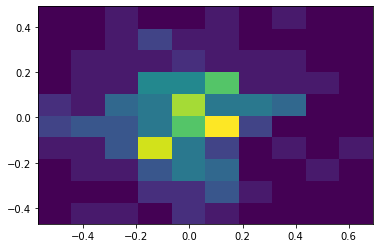

In [22]:
_ = plt.hist2d(xs[:,0], xs[:,1])

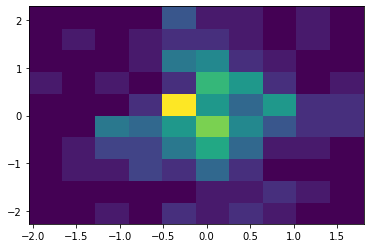

In [23]:
_ = plt.hist2d(ys[:,0], ys[:,1])

We can also inspect correlations in the data

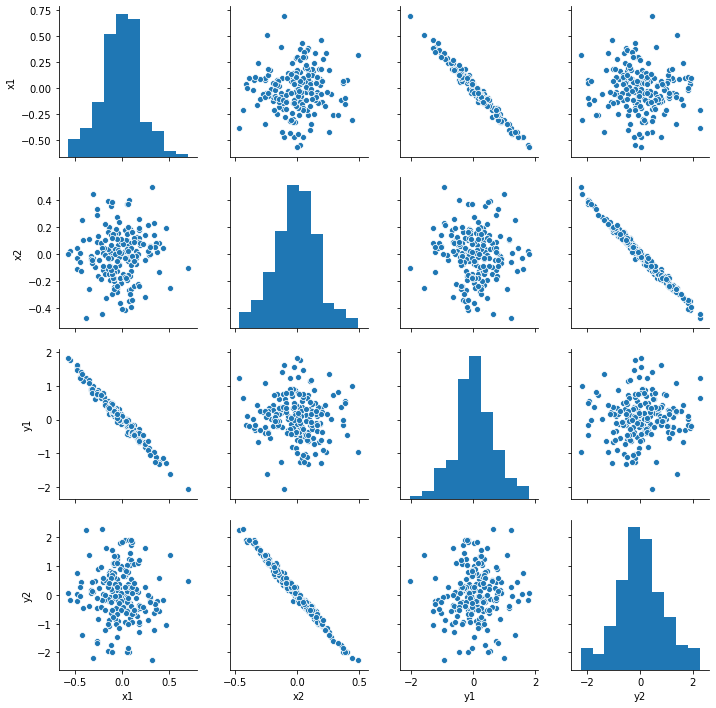

In [24]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"x1": xs[:,0], "x2": xs[:,1], "y1": ys[:,0], "y2": ys[:,1]})
sns.pairplot(df)

In [25]:
n_samples=len(xs)
n_test = n_samples // 10
n_train = n_samples - n_test
n_samples, n_train, n_test 

(200, 180, 20)

Here we will formulate our own model, which here consists out of some trainable parameters (contained in `self.dense`) and an implementation of the forward pass `call(self, inputs)`

In [26]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense = tf.keras.layers.Dense(2, use_bias=False)

    def call(self, inputs):
        return self.dense(inputs)

model = MyModel()

In order to optimize the model to fit our data, we have to specify an optimization criterion. In our case we aim to minimize the mean squared error of our model $F_W=f_w$ on the observed data $(x_n, y_n), ~ n \in [N]$ with respect to the parameters $w$:

$$w_{*} = \arg\min_{w} \tfrac{1}{N} \sum_{n=1}^{N}(f_{w}(x_i) - y_i)^{2}$$

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss=tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.mean_squared_error])
model.build((None, 2))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(xs[:n_train], ys[:n_train], epochs=200,
          validation_data=(xs[n_train:], ys[n_train:]))

Train on 180 samples, validate on 20 samples
Epoch 1/200
180/180 [==============================] - 0s 653us/sample - loss: 0.5257 - mean_squared_error: 0.5257 - val_loss: 0.5106 - val_mean_squared_error: 0.5106
Epoch 2/200
180/180 [==============================] - 0s 70us/sample - loss: 0.5078 - mean_squared_error: 0.5078 - val_loss: 0.4918 - val_mean_squared_error: 0.4918
Epoch 3/200
180/180 [==============================] - 0s 81us/sample - loss: 0.4900 - mean_squared_error: 0.4900 - val_loss: 0.4740 - val_mean_squared_error: 0.4740
Epoch 4/200
180/180 [==============================] - 0s 87us/sample - loss: 0.4728 - mean_squared_error: 0.4728 - val_loss: 0.4569 - val_mean_squared_error: 0.4569
Epoch 5/200
180/180 [==============================] - 0s 91us/sample - loss: 0.4568 - mean_squared_error: 0.4568 - val_loss: 0.4398 - val_mean_squared_error: 0.4398
Epoch 6/200
180/180 [==============================] - 0s 117us/sample - loss: 0.4412 - mean_squared_error: 0.4412 - val_los

Epoch 50/200
180/180 [==============================] - 0s 80us/sample - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0836 - val_mean_squared_error: 0.0836
Epoch 51/200
180/180 [==============================] - 0s 88us/sample - loss: 0.0808 - mean_squared_error: 0.0808 - val_loss: 0.0804 - val_mean_squared_error: 0.0804
Epoch 52/200
180/180 [==============================] - 0s 71us/sample - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.0775 - val_mean_squared_error: 0.0775
Epoch 53/200
180/180 [==============================] - 0s 73us/sample - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.0745 - val_mean_squared_error: 0.0745
Epoch 54/200
180/180 [==============================] - 0s 84us/sample - loss: 0.0715 - mean_squared_error: 0.0715 - val_loss: 0.0716 - val_mean_squared_error: 0.0716
Epoch 55/200
180/180 [==============================] - 0s 85us/sample - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0690 - val_mean_squared_error: 0.069

Epoch 99/200
180/180 [==============================] - 0s 91us/sample - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 100/200
180/180 [==============================] - 0s 116us/sample - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 101/200
180/180 [==============================] - 0s 115us/sample - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 102/200
180/180 [==============================] - 0s 110us/sample - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 103/200
180/180 [==============================] - 0s 94us/sample - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 104/200
180/180 [==============================] - 0s 127us/sample - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0149 - val_mean_squared_err

Epoch 148/200
180/180 [==============================] - 0s 79us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 149/200
180/180 [==============================] - 0s 62us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 150/200
180/180 [==============================] - 0s 99us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 151/200
180/180 [==============================] - 0s 94us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 152/200
180/180 [==============================] - 0s 103us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 153/200
180/180 [==============================] - 0s 76us/sample - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0099 - val_mean_squared_error

Epoch 197/200
180/180 [==============================] - 0s 82us/sample - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 198/200
180/180 [==============================] - 0s 109us/sample - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 199/200
180/180 [==============================] - 0s 127us/sample - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 200/200
180/180 [==============================] - 0s 102us/sample - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0096 - val_mean_squared_error: 0.0096


In [29]:
model.metrics[0].result().numpy()

0.009600508

In [30]:
model.dense.weights

[<tf.Variable 'dense_4/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-3.015784  ,  0.03599377],
        [ 0.01064597, -4.9894624 ]], dtype=float32)>]

In [31]:
n = 100
x = np.linspace(-0.5,0.5,n)
y = np.linspace(-0.5,0.5,n)
X, Y = np.meshgrid(x,y)

samples = np.stack((X,Y), axis=-1)
samples_flat = np.reshape(samples, (n*n, 2))
res_flat = model.apply(samples_flat)
res = np.reshape(res_flat, (n,n,2))
z1 = res[..., 0]
z2 = res[..., 1]

Text(0, 0.5, '$x_2$')

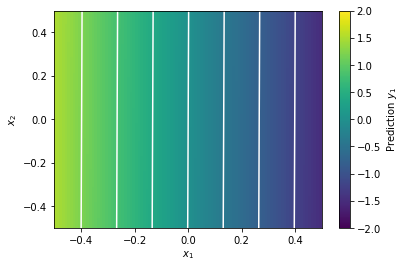

In [32]:
pcol = plt.pcolor(X, Y, z1, vmin=-2.0,vmax=2.0)
plt.contour(X, Y, z1, colors="white", linestyles="-")
cbar = plt.colorbar(pcol)
cbar.ax.set_ylabel(r"Prediction $y_1$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Text(0, 0.5, '$x_2$')

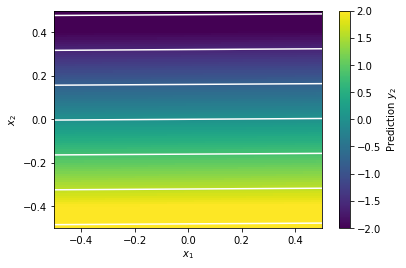

In [33]:
pcol = plt.pcolor(X, Y, z2, vmin=-2.0,vmax=2.0)
plt.contour(X, Y, z2, colors="white", linestyles="-")
cbar = plt.colorbar(pcol)
cbar.ax.set_ylabel(r"Prediction $y_2$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Let's save the weights to file for later usage. In particular this will write a single [checkpoint](https://www.tensorflow.org/beta/guide/checkpoints).

In [34]:
model.save_weights("./hooke-model")

In [35]:
!ls | grep hooke-model

hooke-model.data-00000-of-00001
hooke-model.index


In [36]:
loaded = MyModel()
loaded.build((None, 2))
loaded.load_weights("./hooke-model")
loaded.dense.weights

[<tf.Variable 'dense_5/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-3.015784  ,  0.03599377],
        [ 0.01064597, -4.9894624 ]], dtype=float32)>]

### 4) Overfitting
- Checkpointing with `keras.callbacks.ModelCheckpoint`
- Visualize training metrics using `history`

In the previous example we knew exactly how many parameters are required to reconstruct the given data (up to noise). In the general case, the optimal complexity of a model is not known _a priori_.

To demonstrate this let's use a model with much more parameters than there are datapoints. In other words, the model is much too expressive for the problem and the amount of data we have.

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
_________________________________________________________________


In [39]:
checkpoint_dir = "./overfit_ckpts"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, "of-model"))

In [40]:
history = model.fit(x_train[::1000], y_train[::1000], epochs=40, validation_data=(x_test, y_test), 
                    callbacks=[model_checkpoint], batch_size=64)

Train on 60 samples, validate on 10000 samples
Epoch 1/40
60/60 [==============================] - 2s 26ms/sample - loss: 2.3218 - sparse_categorical_accuracy: 0.0833 - val_loss: 2.2263 - val_sparse_categorical_accuracy: 0.2288
Epoch 2/40
60/60 [==============================] - 1s 14ms/sample - loss: 2.0861 - sparse_categorical_accuracy: 0.4833 - val_loss: 2.1479 - val_sparse_categorical_accuracy: 0.2868
Epoch 3/40
60/60 [==============================] - 1s 18ms/sample - loss: 1.8970 - sparse_categorical_accuracy: 0.6833 - val_loss: 2.0656 - val_sparse_categorical_accuracy: 0.3415
Epoch 4/40
60/60 [==============================] - 1s 25ms/sample - loss: 1.7048 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.9704 - val_sparse_categorical_accuracy: 0.4174
Epoch 5/40
60/60 [==============================] - 1s 20ms/sample - loss: 1.4937 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.8584 - val_sparse_categorical_accuracy: 0.5030
Epoch 6/40
60/60 [==============================

In [41]:
history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [42]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

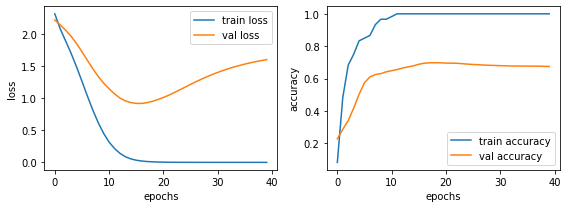

In [43]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

plt.sca(axes[0])
plt.plot(history.epoch, history.history["loss"], label="train loss")
plt.plot(history.epoch, history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.yscale("log")

plt.sca(axes[1])
plt.plot(history.epoch, history.history["sparse_categorical_accuracy"],
         label="train accuracy")
plt.plot(history.epoch, history.history["val_sparse_categorical_accuracy"], 
         label="val accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

fig.tight_layout()

While the performance on the training set always improves, the performance on "unseen" data declines after some time. This indicates __overfitting__. The model is too complex/expressive/rich in parameters and can learn the training set by heart. Hence it also occurs when you have too few data.

The textbook analogy is doing a polynomial fit, with as many trainable parameters as datapoints.

<img src=https://qph.fs.quoracdn.net/main-qimg-28d4d605380ee139f5079e18bacdf630 width="300">
image taken from quora

Generally overfitting is avoided by choosing a simpler model.
### 5) Underfitting
Let's consider a very simple model with few parameters. In other words, a model that is not expressive enough to fulfill the desired function.

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.MaxPool2D(pool_size=(8,8), input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 3, 3, 1)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                100       
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train2, y_train, epochs=10, validation_data=(x_test2, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 77us/sample - loss: 2.0748 - sparse_categorical_accuracy: 0.2753 - val_loss: 1.9261 - val_sparse_categorical_accuracy: 0.3616
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 1.8513 - sparse_categorical_accuracy: 0.3707 - val_loss: 1.8089 - val_sparse_categorical_accuracy: 0.3945
Epoch 3/10
60000/60000 [==============================] - 4s 61us/sample - loss: 1.7766 - sparse_categorical_accuracy: 0.3829 - val_loss: 1.7617 - val_sparse_categorical_accuracy: 0.3971
Epoch 4/10
60000/60000 [==============================] - 4s 74us/sample - loss: 1.7415 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.7342 - val_sparse_categorical_accuracy: 0.4063
Epoch 5/10
60000/60000 [==============================] - 6s 94us/sample - loss: 1.7216 - sparse_categorical_accuracy: 0.3960 - val_loss: 1.7189 - val_sparse_categorical_accuracy: 0.4154
Epoch 6/10
6000

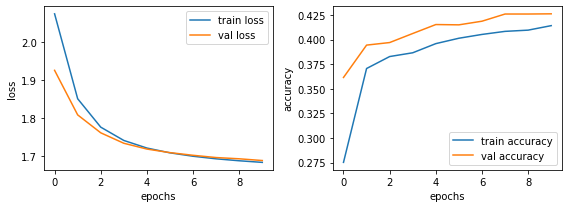

In [47]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

plt.sca(axes[0])
plt.plot(history.epoch, history.history["loss"], label="train loss")
plt.plot(history.epoch, history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.yscale("log")

plt.sca(axes[1])
plt.plot(history.epoch, history.history["sparse_categorical_accuracy"],
         label="train accuracy")
plt.plot(history.epoch, history.history["val_sparse_categorical_accuracy"], 
         label="val accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

fig.tight_layout()

Here we certainly do not overfit, but we cannot even make good predictions on the training data. This is __underfitting__. The model we chose has too little complexity/is too strongly biased.

E.g. consider the prediction of the digit 'five':

<BarContainer object of 10 artists>

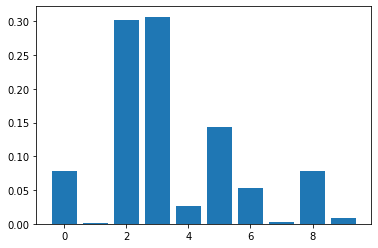

In [48]:
plt.bar(range(10), model.apply(x_train2[0:1]).numpy()[0])

### 6) Regularization
- `tf.train.Checkpoint`
- write own training procedure
- eager execution

Oftentimes it is not clear, which simple model is the right one, i.e. the optimal model bias is not known. Starting from a complex model, __regularization__ prevents overfitting by introducing a systematic bias. Most important regularization methods are:
- Dropout
- Early stopping (`tf.keras.callbacks.EarlyStopping`)
- L1 or L2 penalty on parameters

Going back to the very first MNIST model, where we used dropout.

Note that we will now write our own training procedure which enables us to use tensorflows `tf.train.Checkpoint` and `tf.train.CheckpointManager` (without relying on keras' callback specification).

In [49]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Gather `model`, `optimizer`, `losses` and `metrics`. Note that all these objects are _stateful_. E.g.`SparseCategoricalCrossentropy` is not simply a function but an object that computes and stores the result. This is why we need one metric for each: training loss and validation loss.

In [50]:
model.build((64, 28, 28, 1))

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy')

test_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_sparse_categorical_accuracy')

In [51]:
def train_step(images, labels):
    """
    Predicts the output of `images`, calculates and applies gradients to model parameters.
    Also calculates train metrics
    """
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # calculate metrics
    train_accuracy(labels, predictions)
    train_loss(labels, predictions)

In [52]:
def test_step(images, labels):
    """Evaluates prediction on given data and calculates test metrics"""
    predictions = model(images, training=False)
    # calculate metrics
    test_loss(labels, predictions)
    test_accuracy(labels, predictions)

In [53]:
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

In [54]:
checkpoint_dir = "./regularization_ckpts/"
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=None)
status = checkpoint.restore(manager.latest_checkpoint)

In [55]:
# poor man's history
history = {"epoch": [], "train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

for epoch in tqdm(range(10)):
    for images, labels in train_dataset:
        train_step(images, labels)

    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)

    ckpt_path = manager.save()
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, ckpt {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         tf.round(train_accuracy.result()*1000),
                         test_loss.result(),
                         tf.round(test_accuracy.result()*1000),
                         ckpt_path))
    
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss.result())
    history["train_accuracy"].append(train_accuracy.result())
    history["test_loss"].append(test_loss.result())
    history["test_accuracy"].append(test_accuracy.result())
    
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.2734851837158203, Accuracy: 920.0, Test Loss: 0.12870924174785614, Test Accuracy: 961.0, ckpt ./regularization_ckpts/ckpt-1
Epoch 2, Loss: 0.1279720515012741, Accuracy: 962.0, Test Loss: 0.08903733640909195, Test Accuracy: 972.0, ckpt ./regularization_ckpts/ckpt-2
Epoch 3, Loss: 0.0952165275812149, Accuracy: 971.0, Test Loss: 0.08305729180574417, Test Accuracy: 974.0, ckpt ./regularization_ckpts/ckpt-3
Epoch 4, Loss: 0.07588566094636917, Accuracy: 977.0, Test Loss: 0.07084642350673676, Test Accuracy: 978.0, ckpt ./regularization_ckpts/ckpt-4
Epoch 5, Loss: 0.06541824340820312, Accuracy: 979.0, Test Loss: 0.06950397789478302, Test Accuracy: 978.0, ckpt ./regularization_ckpts/ckpt-5
Epoch 6, Loss: 0.05472831055521965, Accuracy: 983.0, Test Loss: 0.065449558198452, Test Accuracy: 980.0, ckpt ./regularization_ckpts/ckpt-6
Epoch 7, Loss: 0.04813390225172043, Accuracy: 984.0, Test Loss: 0.06422283500432968, Test Accuracy: 980.0, ckpt ./regularization_ckpts/ckpt-7
Epoch 8, Lo

Label tf.Tensor([8], shape=(1,), dtype=uint8)


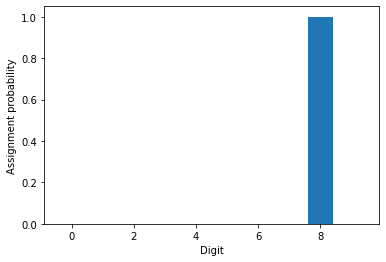

In [56]:
image, label = next(train_dataset.__iter__())
prediction = model(image[0:1], training=False)
plt.bar(range(0,10), prediction[0])
plt.xlabel("Digit")
plt.ylabel("Assignment probability")
print("Label", label[0:1])

In [57]:
model.weights[3]

<tf.Variable 'dense_12/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.05332159, -0.08256638, -0.05437699, -0.09979131,  0.00846671,
        0.00481521, -0.02707016, -0.12905332,  0.30732697,  0.03966857],
      dtype=float32)>

In [58]:
manager.checkpoints

['./regularization_ckpts/ckpt-1',
 './regularization_ckpts/ckpt-2',
 './regularization_ckpts/ckpt-3',
 './regularization_ckpts/ckpt-4',
 './regularization_ckpts/ckpt-5',
 './regularization_ckpts/ckpt-6',
 './regularization_ckpts/ckpt-7',
 './regularization_ckpts/ckpt-8',
 './regularization_ckpts/ckpt-9',
 './regularization_ckpts/ckpt-10']

In [59]:
checkpoint.restore(manager.checkpoints[0])

In [60]:
model.weights[3]

<tf.Variable 'dense_12/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.04213141,  0.01697601,  0.01545415, -0.02875578,  0.00416946,
        0.05732017, -0.00188891,  0.00698155, -0.02369418, -0.00367177],
      dtype=float32)>

Label tf.Tensor([8], shape=(1,), dtype=uint8)


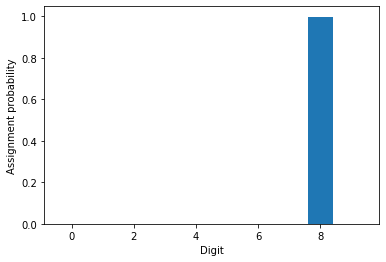

In [61]:
image, label = next(train_dataset.__iter__())
prediction = model.apply(image[0:1])
plt.bar(range(0,10), prediction[0])
plt.xlabel("Digit")
plt.ylabel("Assignment probability")
print("Label", label[0:1])

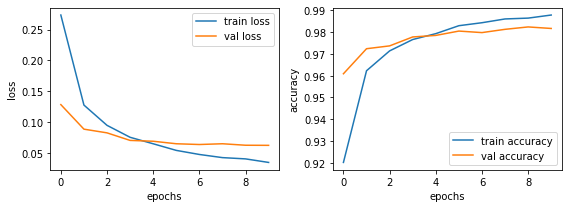

In [62]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

plt.sca(axes[0])
plt.plot(history["epoch"], history["train_loss"], label="train loss")
plt.plot(history["epoch"], history["test_loss"], label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.yscale("log")

plt.sca(axes[1])
plt.plot(history["epoch"], history["train_accuracy"],
         label="train accuracy")
plt.plot(history["epoch"], history["test_accuracy"], 
         label="val accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

fig.tight_layout()

### 7) MNIST Autoencoder, fill-in-the-blank exercise
![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/220px-Autoencoder_schema.png)
(wikipedia)

We now want to learn a compressed representation of the MNIST dataset by building an __Autoencoder__, which comprises of:
- an Encoder, that takes the input image and compresses it to a lower dimensional (latent) representation
- a Decoder, which takes the output of the encoder and expands it again into the original pixel reprensentation

The target is to minimize the reconstruction of this feed forward model. This is an __unsupervised__ method, which means that we do not use the labels.

The latent representation shall be a vector of a few dimensions (fewer than the 28x28 original image).

Hints: Play around with the activation functions (relu, leaky relu, or sigmoid), and play around with the dimension of the latent space.

Additionally we want to visualize the latent representation of our data using t-SNE (can be done in tensorboard e.g. https://projector.tensorflow.org/)

In [63]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.... = ### FILL
    
    def call(self, inputs):
        ### FILL
        return ### FILL
    
class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.... = ### FILL
    
    def call(self, inputs):
        ### FILL
        return ### FILL

class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, inputs):
        ### FILL
        return ### FILL

SyntaxError: invalid syntax (<ipython-input-63-3e6860831c82>, line 4)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1024).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, x_test)).shuffle(1024).batch(32)

In [ ]:
dim = ### FILL
ae = Autoencoder(dim)
ae.build((32, 28, 28))
ae.compile(optimizer=tf.keras.optimizers.Adam(),
           loss=tf.keras.losses.MeanSquaredError(),
           metrics=[tf.keras.metrics.MeanSquaredError()])
ae.summary()

In [ ]:
history = ae.fit(train_ds, epochs=5, validation_data=test_ds)

In [ ]:
plt.plot(history.epoch, history.history["loss"], label="train loss")
plt.plot(history.epoch, history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

Lets look at some predictions

In [ ]:
for images, _ in train_ds.take(1):
    n_images = len(images)
    n_cols = 8
    n_rows = 2*n_images // n_cols
    
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*1.5,n_rows*1.5))
    axes = axes.flatten()
    
    predictions = ae.call(images)
    
    for i, image in enumerate(images):
        axes[2*i].matshow(image)
        axes[2*i].set_yticklabels([])
        axes[2*i].set_xticklabels([])
        axes[2*i+1].matshow(predictions[i])
        axes[2*i+1].set_yticklabels([])
        axes[2*i+1].set_xticklabels([])

Get the latent representation of the dataset

In [ ]:
latent = ### FILL (get 1200 images and transform them to the latent represenation)
latent.shape

In [ ]:
labels = ### FILL (get the corresponding 1200 labels)
labels.shape

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.DataFrame({f"{i}": latent[:,i] for i in range(dim)})
df.head()

In [ ]:
sns.pairplot(df)

In [ ]:
import tsne

In [ ]:
proj = tsne.pca(latent.numpy().astype(np.float64), no_dims=2)

In [ ]:
scatter = plt.scatter(proj[:,0], proj[:,1], c=labels, cmap=plt.get_cmap("tab10"))
plt.legend(*scatter.legend_elements())

In [ ]:
proj = tsne.tsne(latent.numpy().astype(np.float64), max_iter=300)

In [ ]:
proj.shape

In [ ]:
scatter = plt.scatter(proj[:,0], proj[:,1], c=labels, cmap=plt.get_cmap("tab10"))
plt.legend(*scatter.legend_elements())

## Summary
Tensorflow offers many ways to create models and train them:
- More high level methods conform to the Keras specification.
- Using lower level methods gives more control (write own model and training loop).

Combinations of these are quite interoperable

In detail we have learned:
- Construct models of type `tf.keras.Model` via the sequential API, the functional API, or writing your own subclass
- Choose loss function, optimizer, and metrics
- Supply data directly from numpy arrays or `tf.data.Dataset`
- Train via `model.fit()` or writing your own training loop, e.g.
```python
for i in range(n_epochs):
    for xs, ys in dataset:
        with tf.GradientTape() as tape:
            predictions = model(xs)
            loss = loss_object(ys, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
```
- History of training metrics is automatically returned by `model.fit()`. In your own training loop you can do anything, e.g. fill a list of metrics yourself. (Tomorrow you'll learn about `tensorboard`)
- Saving a model means using checkpoints, which is done via 
    - `keras.ModelCheckpoint` and `model.fit(..., callbacks=...)`, or
    - write your own loop and use a `tf.train.Checkpoint` and `tf.train.CheckpointManager`